# Main Program
Author: Adam Darmanin and Owen Fava

Install spacy vocab: `python -m spacy download en_core_web_md`

In [1]:
import ast
import matplotlib.pyplot as plt
import networkx as nx
import nltk
import numpy as np
import pandas as pd
import spacy
from empath import Empath

from nltk.sentiment import SentimentIntensityAnalyzer
from stellargraph import StellarGraph
from tensorflow.keras.models import load_model
from tqdm import tqdm
from stellargraph.layer import GraphConvolution

nlp = spacy.load("en_core_web_md")
nltk.download("words")
nltk.download('vader_lexicon')
psy_ner = spacy.load("./model/psy_ner")

C:\Users\adamd\AppData\Local\Temp\ipykernel_20220\1762579991.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\adamd\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\adamd\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
from lib.sanitze_util import clean_text_batch

# Interactive : user_input = input("Enter your input: ")
user_input = "I am in a really dark moment in my life right now. My husband is a controlling pos that believes heâ€™s a doctor and doesnâ€™t allow me to get any kind of treatment for my BPD. I recently moved to his country and I am unable to do anything by myself (I donâ€™t speak Korean), also he keeps the salary of my job so I donâ€™t have money. I canâ€™t move back to my country either, my family stopped to talk to me because I married him, so how can I cope with all the suicide thoughts I have everyday? I also suffer from anger management issues and without medicine, I canâ€™t control myself and we fight a lot. I feel really lonely here, he works 24/7, but I prefer that than being with him honestly. Heâ€™s controlling and even violent sometimes. What do you recommend to treat my BPD?"

cleaned_sentence = clean_text_batch([user_input])[0]
print(f"Original sentence: {user_input}")
print(f"Cleaned sentence: {cleaned_sentence}")

Cleaning Pipeline Token:   0%|          | 0/1 [00:00<?, ?it/s]c:\Users\adamd\.conda\envs\gnn\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
Cleaning Pipeline Token: 100%|██████████| 1/1 [00:00<00:00, 76.84it/s]

Original sentence: I am in a really dark moment in my life right now. My husband is a controlling pos that believes heâ€™s a doctor and doesnâ€™t allow me to get any kind of treatment for my BPD. I recently moved to his country and I am unable to do anything by myself (I donâ€™t speak Korean), also he keeps the salary of my job so I donâ€™t have money. I canâ€™t move back to my country either, my family stopped to talk to me because I married him, so how can I cope with all the suicide thoughts I have everyday? I also suffer from anger management issues and without medicine, I canâ€™t control myself and we fight a lot. I feel really lonely here, he works 24/7, but I prefer that than being with him honestly. Heâ€™s controlling and even violent sometimes. What do you recommend to treat my BPD?
Cleaned sentence: dark moment life right husband controlling pos believes doctor doesn allow kind treatment bpd recently moved country unable don speak korean keeps salary job don money country fam

In [3]:
# ADAM: Reuse the libs we created instead of duplicating functions
from lib.feature_engineering import create_rel_feature,create_psylabel_feature,create_sentiment_feature,create_emotional_categories_scores_feature
tqdm.pandas()

data = pd.DataFrame({"title": ["HELP!"], "selftext": [cleaned_sentence], "sentence": [cleaned_sentence]})

data["psy_labels"]=data.progress_apply(create_psylabel_feature, axis=1)
data["sentiment"]=data.progress_apply(create_sentiment_feature, axis=1)
data["emotional_categories"]=data.progress_apply(create_emotional_categories_scores_feature, axis=1)
data["semantic_relationships"]=data.progress_apply(create_rel_feature, axis=1)
print(data)

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\adamd\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\adamd\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
100%|██████████| 1/1 [00:00<00:00, 333.36it/s]

   title                                           selftext  \
0  HELP!  dark moment life right husband controlling pos...   

                                            sentence               psy_labels  \
0  dark moment life right husband controlling pos...  {'SYMPTOMS': ['anger']}   

                              semantic_relationships  sentiment  \
0  [(believes, nsubj, husband), (controlling, dob...    -0.7881   

                                emotional_categories  
0  {'help': 0.02, 'violence': 0.05, 'sleep': 0.0,...  


In [4]:
clean_data = []

data = data.reset_index(drop=True)
labels = data.iloc[0]["psy_labels"]
relationships = data["semantic_relationships"]
sentence = data.iloc[0]["sentence"]

for relationship in relationships:
    for rel in relationship:
        if len(rel) == 3:
            word1, dep, word2 = rel
            clean_data.append(
                {
                    "Word1": word1,
                    "Dependency": dep,
                    "Word2": word2,
                    "MHlabels": labels,
                    "sentence": sentence
                }
            )
        else:
            print(f"Issue with relationship: {rel}")

clean_data_frame = pd.DataFrame(clean_data)
print(clean_data_frame)

          Word1 Dependency     Word2                 MHlabels  \
0      believes      nsubj   husband  {'SYMPTOMS': ['anger']}   
1   controlling       dobj       pos  {'SYMPTOMS': ['anger']}   
2         allow      nsubj     doesn  {'SYMPTOMS': ['anger']}   
3         moved      nsubj       bpd  {'SYMPTOMS': ['anger']}   
4         moved       dobj   country  {'SYMPTOMS': ['anger']}   
5         keeps      nsubj    korean  {'SYMPTOMS': ['anger']}   
6       stopped      nsubj    family  {'SYMPTOMS': ['anger']}   
7        suffer      nsubj  thoughts  {'SYMPTOMS': ['anger']}   
8          feel      nsubj       lot  {'SYMPTOMS': ['anger']}   
9          feel       dobj     works  {'SYMPTOMS': ['anger']}   
10  controlling       dobj       bpd  {'SYMPTOMS': ['anger']}   

                                             sentence  
0   dark moment life right husband controlling pos...  
1   dark moment life right husband controlling pos...  
2   dark moment life right husband controlling pos.

Processing Rows: 100%|██████████| 11/11 [00:00<00:00, 11006.05it/s]


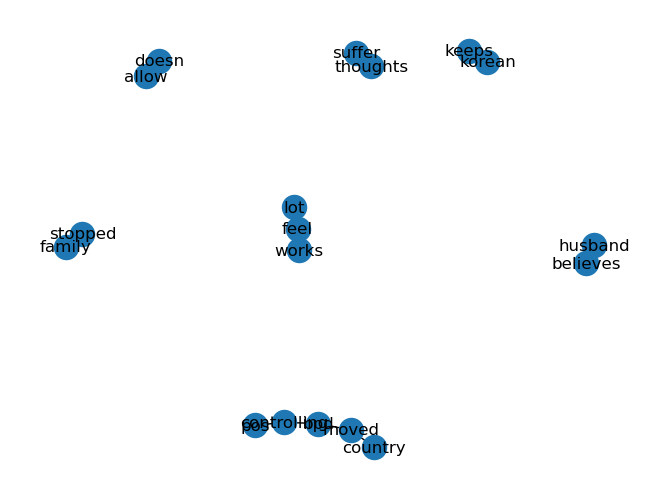

In [5]:
graph = nx.Graph()

for row in tqdm(clean_data_frame.itertuples(), total=len(clean_data_frame), desc="Processing Rows", position=0):
    word1_lowercase = row.Word1.lower()
    graph.add_node(word1_lowercase)

    word2_lowercase = row.Word2.lower()
    graph.add_node(word2_lowercase)

    mh_labels_dict = ast.literal_eval(str(row.MHlabels))

    # Determine the relationship direction based on 'Dependency'
    if row.Dependency == 'dobj':
        graph.add_edge(word1_lowercase, word2_lowercase, dependency=row.Dependency, label={**mh_labels_dict})
    elif row.Dependency == 'nsubj':
        graph.add_edge(word1_lowercase, word2_lowercase, dependency=row.Dependency, label={**mh_labels_dict})
    else:
        continue

nx.draw(graph, with_labels=True)
plt.show()

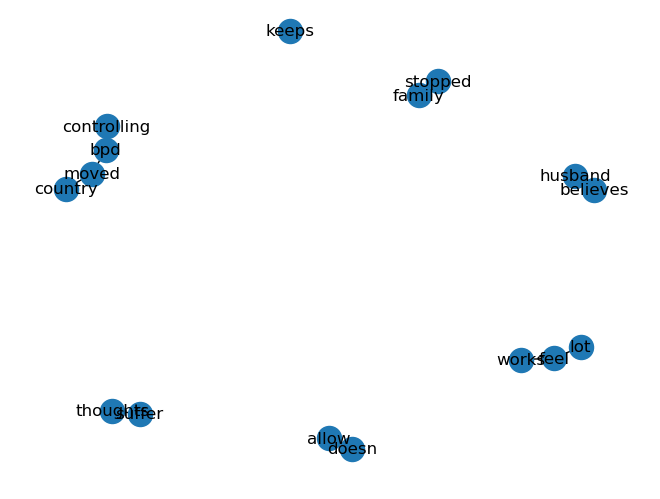

In [6]:
from gensim.models import KeyedVectors, Word2Vec

VEC_FILE = "./data/word2vec_embeddings.bin"
# word_embeddings = KeyedVectors.load(VEC_FILE,  mmap='r')
# ADAM: This was taken from your
word_embeddings = Word2Vec.load(VEC_FILE)
node_to_remove = []
for node in graph.nodes:
    if node in word_embeddings.wv:
        attrs = {node: {"embedding": word_embeddings.wv[node]}}
        nx.set_node_attributes(graph, attrs)
    else:
       # ADAM: Why are you removing the nodes?
       node_to_remove.append(node)

for node in node_to_remove:
    graph.remove_node(node)


nx.draw(graph, with_labels=True)
plt.show()

In [61]:
node_data = {node: data for node, data in graph.nodes(data=True)}
node_mapping = {node: idx for idx, node in enumerate(node_data.keys())}
node_df = pd.DataFrame.from_dict({(node_mapping[node]): values["embedding"] for node, values in node_data.items()}, orient="index").reset_index()

embeddings = [(node_mapping[node], hash(tuple(values['embedding'])) ) for node, values in node_data.items()]
node_df = pd.DataFrame(embeddings)
node_df.columns = ['node_id', "embedding"]
node_df.set_index('node_id', inplace=True)

edge_data = [(source, target) for source, target, __ in graph.edges(data=True)]
edge_df = pd.DataFrame(edge_data, columns=['source', 'target'])
source_nodes = pd.Series(edge_df["source"])
target_nodes = pd.Series(edge_df["target"])
edge_df = pd.concat([source_nodes, target_nodes], axis=1)
edge_df.replace(node_mapping, inplace=True)

stellar_graph = StellarGraph(nodes=node_df, edges=edge_df)
print(stellar_graph.info())

StellarGraph: Undirected multigraph
 Nodes: 16, Edges: 9

 Node types:
  default: [16]
    Features: float32 vector, length 1
    Edge types: default-default->default

 Edge types:
    default-default->default: [9]
        Weights: all 1 (default)
        Features: none


C:\Users\adamd\AppData\Local\Temp\ipykernel_20220\3579500535.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  edge_df.replace(node_mapping, inplace=True)


In [62]:
model = load_model("models/model_fold_1.h5", custom_objects={"GraphConvolution": GraphConvolution})
assert  model is not None

In [92]:
from stellargraph.mapper import FullBatchNodeGenerator,PaddedGraphGenerator

# Initialize the generator
generator = PaddedGraphGenerator([stellar_graph])

all_gen = generator.flow([0], targets=[0])

MH_LABELS = ['anxiety', 'bpd', 'depression', 'schizophrenia', 'mentalillness', 'bipolar']
pred = model.predict(all_gen)

label = np.argmax(pred, axis=1)[0]
print(label)
print("Predicted Labels:", MH_LABELS[label])

1/1 [==============================] - 0s 67ms/step
5
Predicted Labels: bipolar
